<a href="https://colab.research.google.com/github/JamesMcGuigan/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/NLP_Week4_Exercise_Shakespeare_Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow==2.1.0 -q

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
import tensorflow.keras.utils as ku 
import tensorflow as tf
import numpy as np 

In [3]:
tokenizer = Tokenizer()
!wget -c --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2020-03-26 03:27:54--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.28.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.28.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2020-03-26 03:27:55 (115 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [4]:
label.shape

(15462, 3211)

In [9]:
model = Sequential()
model.add(tf.keras.layers.Embedding(total_words, 100, trainable=False))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, activation='relu', return_sequences=True)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, activation='relu', return_sequences=True)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.LSTM(256, activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(total_words/2, activation='relu', kernel_regularizer=l2(0.01)))
model.add(tf.keras.layers.Dense(total_words/2, activation='relu', kernel_regularizer=l2(0.01)))
model.add(tf.keras.layers.Dense(total_words, activation='softmax'))

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01), 
    loss=tf.keras.losses.CategoricalCrossentropy(), 
    metrics=['accuracy']
)
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         321100    
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 512)         731136    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 512)         0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 512)         1574912   
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 512)         0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 256)               787456    
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)              

In [10]:
history = model.fit(predictors, label, epochs=100, verbose=1)

Train on 15462 samples
Epoch 1/100
15462/15462 [==============================] - 24s 2ms/sample - loss: 38.8107 - accuracy: 0.0213
Epoch 2/100
15462/15462 [==============================] - 21s 1ms/sample - loss: 12.5671 - accuracy: 0.0215
Epoch 3/100
15462/15462 [==============================] - 21s 1ms/sample - loss: 9.7246 - accuracy: 0.0205
Epoch 4/100
15462/15462 [==============================] - 21s 1ms/sample - loss: 8.2180 - accuracy: 0.0208
Epoch 5/100
15462/15462 [==============================] - 20s 1ms/sample - loss: 7.4116 - accuracy: 0.0212
Epoch 6/100
15462/15462 [==============================] - 20s 1ms/sample - loss: 6.9916 - accuracy: 0.0196
Epoch 7/100
15462/15462 [==============================] - 21s 1ms/sample - loss: 6.7751 - accuracy: 0.0224
Epoch 8/100
15462/15462 [==============================] - 20s 1ms/sample - loss: 6.6657 - accuracy: 0.0221
Epoch 9/100
15462/15462 [==============================] - 20s 1ms/sample - loss: 6.6091 - accuracy: 0.0206
Epo

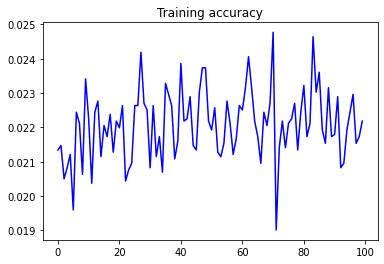

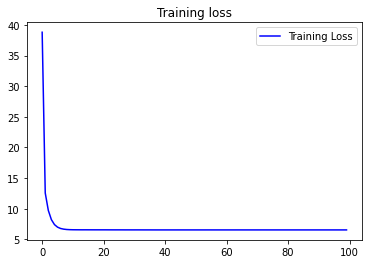

In [11]:
import matplotlib.pyplot as plt
acc  = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [12]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted  = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
